In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [ ]:
#load and preprocess data
from sklearn.preprocessing import MinMaxScaler
import joblib
import pandas as pd

# Load and inspect
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

# Clean
data = data.dropna().drop_duplicates()

# Convert boolean columns to int
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
                   'domain_spf', 'tls_ssl_certificate', 'url_google_index',
                   'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Identify numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]

# Scale using MinMaxScaler only
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

# Save
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into features and labels
X = data.drop(columns=['phishing']).values
y = data['phishing'].values

# Splitting into training and test sets
X_train_dae, X_test_dae, y_train_dae, y_test_dae = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 4: Reshape — for DAE (dense), no reshaping needed
input_dim = X_train.shape[1]
print("Input dimension for DAE:", input_dim)


Input dimension for DAE: 111


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Custom Neural Field Attention Layer
class NeuralFieldAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(NeuralFieldAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', trainable=True)
        self.built = True

    def call(self, inputs):
        Q = K.dot(inputs, self.Wq)
        K_ = K.dot(inputs, self.Wk)
        V = K.dot(inputs, self.Wv)

        attention_scores = tf.nn.softmax(tf.matmul(Q, K_, transpose_b=True) / tf.sqrt(tf.cast(self.units, tf.float32)), axis=-1)
        attention_output = tf.matmul(attention_scores, V)
        return attention_output

# Input Layer
input_dim = X_train_dae.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Attention Layer
attention = NeuralFieldAttention(units=32)(encoded)
attention = LayerNormalization()(attention)

# Decoder
decoded = Dense(64, activation='relu')(attention)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Model
dae_attention_model = Model(inputs=input_layer, outputs=decoded)
dae_attention_model.compile(optimizer='adam', loss='mse')
dae_attention_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 111)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention               │ (None, 32)                  │           3,072 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 32)                  │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 111)                 │           7,215 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,711 (84.81 KB)

 Trainable params: 21,711 (84.81 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 6: Model Training
history_dae = dae_attention_model.fit(
    X_train_dae, X_train_dae,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_dae, X_test_dae)
)


Epoch 1/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0196 - val_loss: 0.0051
Epoch 2/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 3/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 9/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 11/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 12/50
2181/2181 ━━━━━━

In [ ]:
# Step 8: Reconstruct inputs and compute reconstruction error
X_test_pred = dae_attention_model.predict(X_test_dae)
reconstruction_errors = np.mean(np.power(X_test_dae - X_test_pred, 2), axis=1)

# Define threshold using training reconstruction errors
X_train_pred = dae_attention_model.predict(X_train_dae)
train_errors = np.mean(np.power(X_train_dae - X_train_pred, 2), axis=1)
threshold = np.percentile(train_errors, 95)  # You can change this percentile

# Convert reconstruction errors into binary predictions
y_pred_dae = (reconstruction_errors > threshold).astype(int)


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
# Step 9: Evaluate predictions
accuracy_dae = accuracy_score(y_test, y_pred_dae)
precision_dae = precision_score(y_test, y_pred_dae)
recall_dae = recall_score(y_test, y_pred_dae)
auc_dae = roc_auc_score(y_test, y_pred_dae)
conf_matrix_dae = confusion_matrix(y_test, y_pred_dae)


In [ ]:
# Step 10: Print evaluation metrics
print("\nMetrics (DAE with Attention):")
print(f"Accuracy: {accuracy_dae:.4f}")
print(f"Precision: {precision_dae:.4f}")
print(f"Recall: {recall_dae:.4f}")
print(f"AUC: {auc_dae:.4f}")
print("Confusion Matrix:")
print(conf_matrix_dae)

# FAR and FRR calculations
fp, fn = conf_matrix_dae[0][1], conf_matrix_dae[1][0]
tn, tp = conf_matrix_dae[0][0], conf_matrix_dae[1][1]
far_dae = fp / (fp + tn)
frr_dae = fn / (fn + tp)
print("\nFAR:", round(far_dae, 4))
print("FRR:", round(frr_dae, 4))



Metrics (DAE with Attention):
Accuracy: 0.6343
Precision: 0.3417
Recall: 0.0494
AUC: 0.4991
Confusion Matrix:
[[10763   580]
 [ 5798   301]]

FAR: 0.0511
FRR: 0.9506


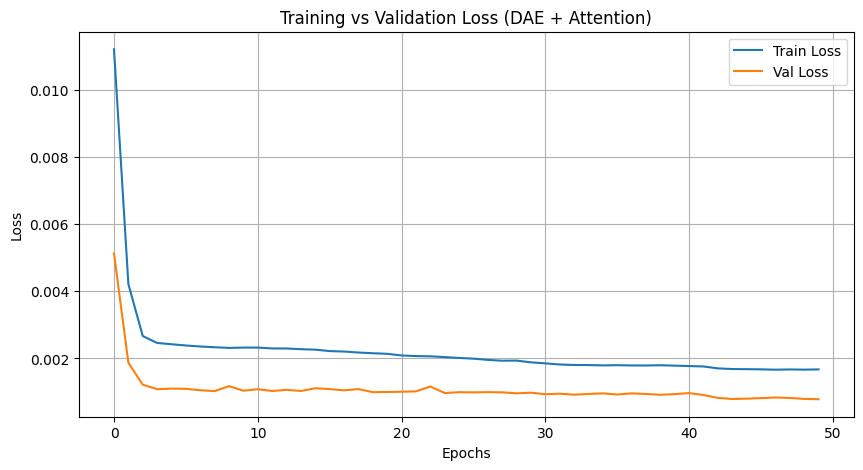

In [ ]:
# Step 11: Save and plot training loss
np.save("model_history_dae_attention.npy", history_dae.history)

plt.figure(figsize=(10, 5))
plt.plot(history_dae.history['loss'], label='Train Loss')
plt.plot(history_dae.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss (DAE + Attention)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
